In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [36]:
# Define dataset path
dataset_dir = "dataset_L_R"  # Replace with your actual dataset path
class_names = sorted([
    d for d in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, d))
])

# Get image file paths and labels
file_paths = []
labels = []

for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(fpath)
            labels.append(label_index)

file_paths = np.array(file_paths)
labels = np.array(labels)


In [37]:
# Stratified train/test split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(file_paths, labels):
    X_train, X_test = file_paths[train_idx], file_paths[val_idx]
    y_train_raw, y_test_raw = labels[train_idx], labels[val_idx]

print("Train class distribution:", np.bincount(y_train_raw))
print("Val class distribution:", np.bincount(y_test_raw))

Train class distribution: [40 43]
Val class distribution: [10 11]


In [38]:
# Preprocess image files to array
def preprocess_images(paths, target_size=(224, 224)):
    images = []
    for path in paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

In [39]:
X_train_images = preprocess_images(X_train)
X_test_images = preprocess_images(X_test)

In [40]:
# Load MobileNet base model
base_model = MobileNet(input_shape=(224, 224, 3),
                       include_top=True,
                       weights='imagenet')
base_model.trainable = True

In [41]:
# Add custom layers
x = base_model.output
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [42]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
# Train model
# history = model.fit(X_train_images, y_train_raw, epochs=10, batch_size=4, validation_split=0.2)
from tensorflow.keras.callbacks import EarlyStopping
import time
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_images, y_train_raw, epochs=1000, batch_size=4, validation_split=0.2, callbacks=[early_stopping])
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.4631 - loss: 0.6920 - val_accuracy: 0.5294 - val_loss: 0.6933
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5839 - loss: 0.6834 - val_accuracy: 0.4706 - val_loss: 0.6945
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8155 - loss: 0.6764 - val_accuracy: 0.4118 - val_loss: 0.6948
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9852 - loss: 0.6677 - val_accuracy: 0.5294 - val_loss: 0.6958
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9748 - loss: 0.6596 - val_accuracy: 0.4118 - val_loss: 0.6997
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 0.6488 - val_accuracy: 0.4706 - val_loss: 0.6979
Training completed in 17.98 seconds.


In [48]:
# Evaluate model
import time
start_time = time.time()
loss, accuracy = model.evaluate(X_test_images, y_test_raw)
end_time = time.time()
print(f"Inferenceing completed in {end_time - start_time:.2f} seconds.")
print(f'Test Accuracy: {accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step - accuracy: 0.4762 - loss: 0.6958
Inferenceing completed in 0.74 seconds.
Test Accuracy: 47.62%


In [45]:
# Save model
model.save("mobilenet_L_R.h5")
# Load model (optional step, useful for confirmation)
model = tf.keras.models.load_model("mobilenet_L_R.h5")


In [46]:
# Predict on test set
y_pred_probs = model.predict(X_test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


<Figure size 600x600 with 0 Axes>

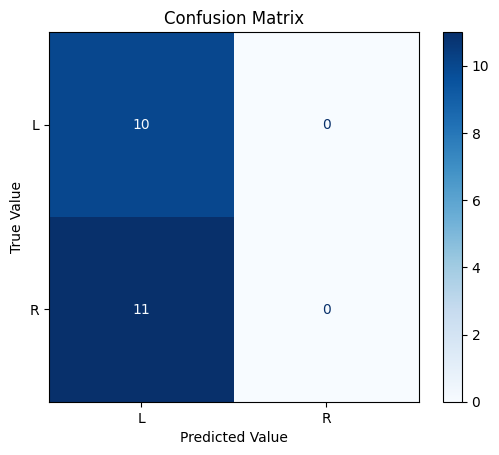

In [47]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()
